<a href="https://colab.research.google.com/github/zeroxiga/ML-Data-Augmentation---SVHN/blob/main/Data%20Augmentation%20-%20SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation - SVHN
## Introduction
When training deep neural networks, the availability of data is a frequent challenge. Acquisition of additional data is often difficult, due to one or both of logistical or financial reasons. As such, methods such as fintuning, and data augmentation are common practices to address the challenge of limited data.

You have been provided with two portions of data from the Street View House Numbers
(SVHN) dataset. SVHN can be seen as a 'real world' MNIST, and although the target classes
are the same, the data within SVHN is far more diverse. The two data portions are:
1. A training set, Q3/q3 train.mat, containing 100 examples of each class (1,000 samples
total).
2. A testing set, Q3/q3 test.mat, containing 1,000 examples of each class (10,000 sam-
ples total).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy.io
from skimage import data, color
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

## Data Preparation
Data loading. We have two datasets to load - Training and Testing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
svhn_train = scipy.io.loadmat('/content/drive/My Drive/CAB420/Assignment 1A/Data/Q3/q3_train.mat')
svhn_test = scipy.io.loadmat('/content/drive/My Drive/CAB420/Assignment 1A/Data/Q3/q3_test.mat')

print('Train Samples Shape:', svhn_train['train_X'].shape)
print('Train Labels Shape:', svhn_train['train_Y'].shape)

print('Test Samples Shape:', svhn_test['test_X'].shape)
print('Test Labels Shape:', svhn_test['test_Y'].shape)

Train Samples Shape: (32, 32, 3, 1000)
Train Labels Shape: (1000, 1)
Test Samples Shape: (32, 32, 3, 10000)
Test Labels Shape: (10000, 1)


       count
class       
1       17.5
2       15.3
3       12.0
4       10.5
5        9.3
6        7.3
7        8.5
8        7.2
9        6.4
10       6.0
       count
class       
1      189.4
2      149.7
3      114.1
4      103.5
5       89.2
6       75.8
7       78.9
8       68.3
9       60.0
10      71.1


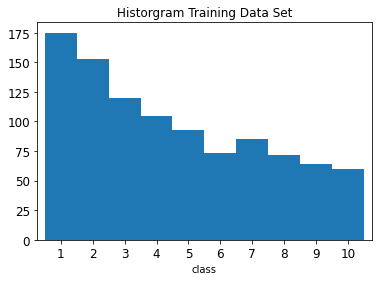

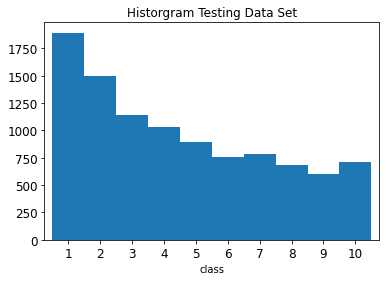

In [ ]:
# Check class distribution
df_training_count = pd.DataFrame(pd.DataFrame(svhn_train['train_Y'].tolist(), columns=['class']).groupby('class').size(), columns=['count'])
df_training_count.plot(kind='bar', title ="Historgram Training Data Set", figsize=(6, 4), legend=False, fontsize=12, rot=0, width=1)
print(round(df_training_count/df_training_count.shape[0],2))

df_testing_count = pd.DataFrame(pd.DataFrame(svhn_test['test_Y'].tolist(), columns=['class']).groupby('class').size(), columns=['count'])
df_testing_count.plot(kind='bar', title ="Historgram Testing Data Set", figsize=(6, 4), legend=False, fontsize=12, rot=0, width=1)
print(round(df_testing_count/df_testing_count.shape[0],2))

In [ ]:
X_train = svhn_train['train_X']
X_train = np.transpose(X_train, (3, 0, 1, 2))
Y_train = svhn_train['train_Y']
Y_train[Y_train==10] = 0

X_test = svhn_test['test_X']
X_test = np.transpose(X_test, (3, 0, 1, 2))
Y_test = svhn_test['test_Y']
Y_test[Y_test==10] = 0

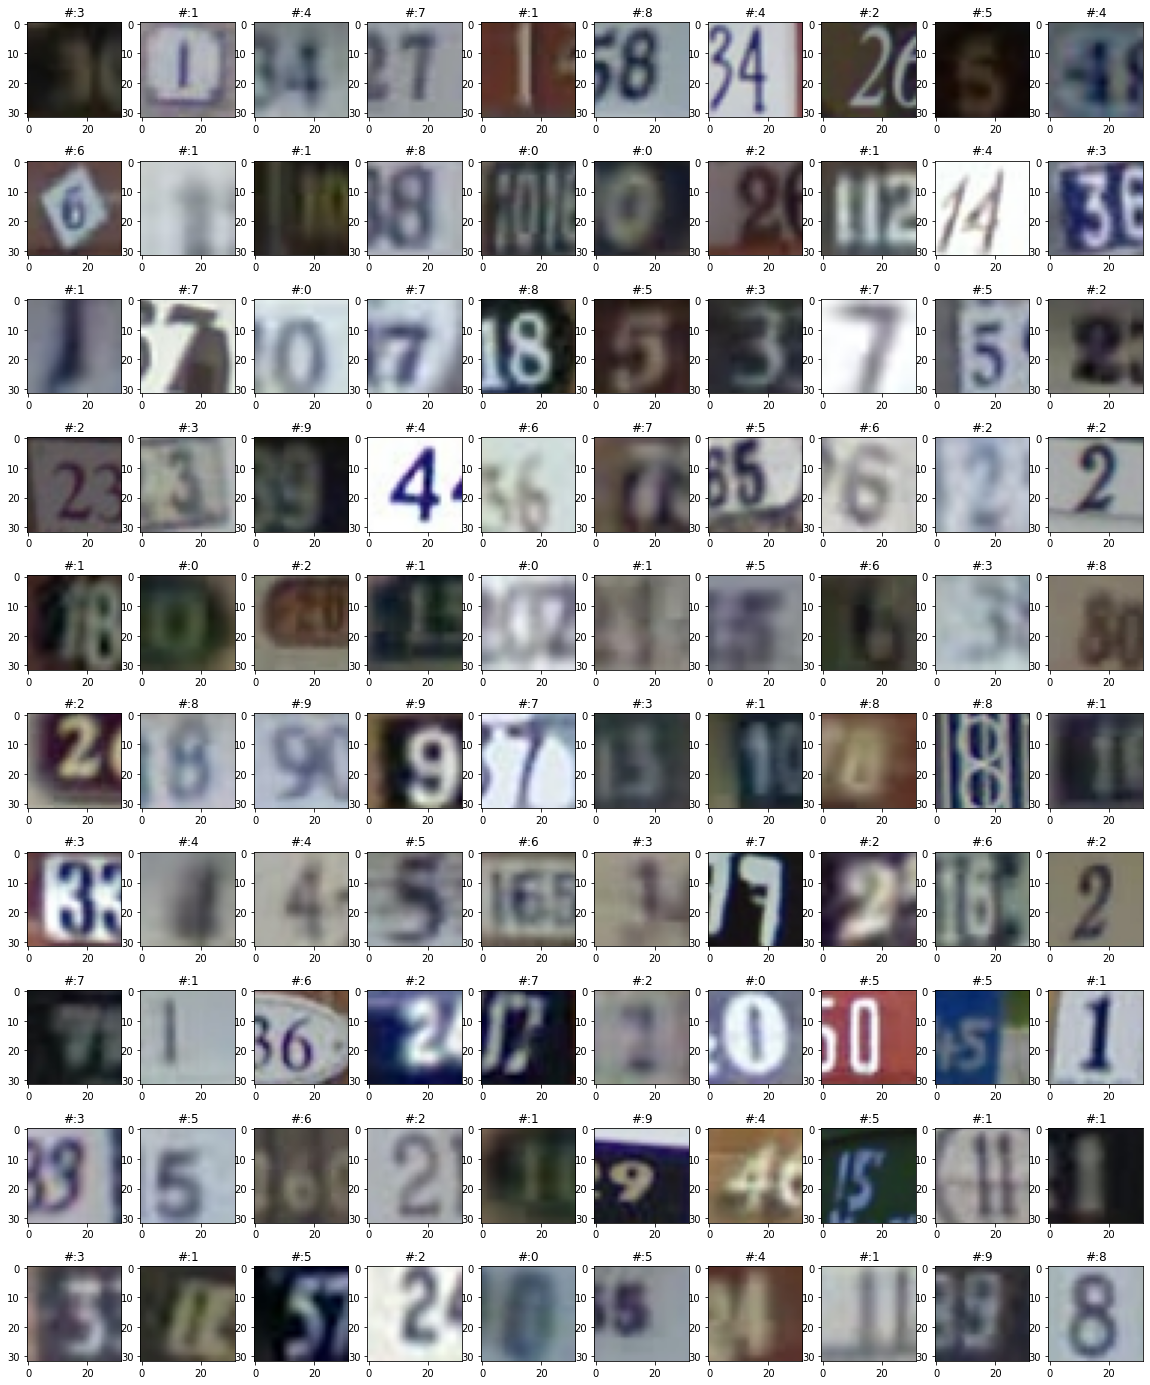

In [ ]:
fig = plt.figure(figsize=[20, 25])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(X_train[i,:,:,:])
    ax.set_title('#:' + '%d' % Y_train[i])

### Functions
Defining our model from scratch and evaluation functions

In [ ]:
num_epochs = 100

def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='model_baseline')
    
    return model_cnn

In [ ]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(np.diagonal(cm)), rwidth=0.95)
    ax.plot(np.diagonal(cm))

In [ ]:
model_baseline = build_model(10)
model_baseline.summary()

Model: "model_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)      

### Training without Augmentation

In [ ]:
model_baseline.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_baseline.fit(X_train, Y_train,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(X_test, Y_test))

Epoch 1/100
8/8 [==============================] - 7s 823ms/step - loss: 2.2884 - accuracy: 0.1490 - val_loss: 2.2626 - val_accuracy: 0.1894
Epoch 2/100
8/8 [==============================] - 6s 788ms/step - loss: 2.2749 - accuracy: 0.1730 - val_loss: 2.2590 - val_accuracy: 0.1894
Epoch 3/100
8/8 [==============================] - 6s 775ms/step - loss: 2.2594 - accuracy: 0.1800 - val_loss: 2.2816 - val_accuracy: 0.1168
Epoch 4/100
8/8 [==============================] - 6s 785ms/step - loss: 2.2717 - accuracy: 0.1670 - val_loss: 2.2715 - val_accuracy: 0.1651
Epoch 5/100
8/8 [==============================] - 6s 786ms/step - loss: 2.2624 - accuracy: 0.1870 - val_loss: 2.2553 - val_accuracy: 0.1896
Epoch 6/100
8/8 [==============================] - 6s 780ms/step - loss: 2.2528 - accuracy: 0.1880 - val_loss: 2.2516 - val_accuracy: 0.2054
Epoch 7/100
8/8 [==============================] - 6s 779ms/step - loss: 2.2563 - accuracy: 0.1930 - val_loss: 2.2603 - val_accuracy: 0.2017
Epoch 8/100
8

313/313 - 5s - loss: 1.7863 - accuracy: 0.6715
Test loss: 1.7862812280654907
Test accuracy: 0.671500027179718


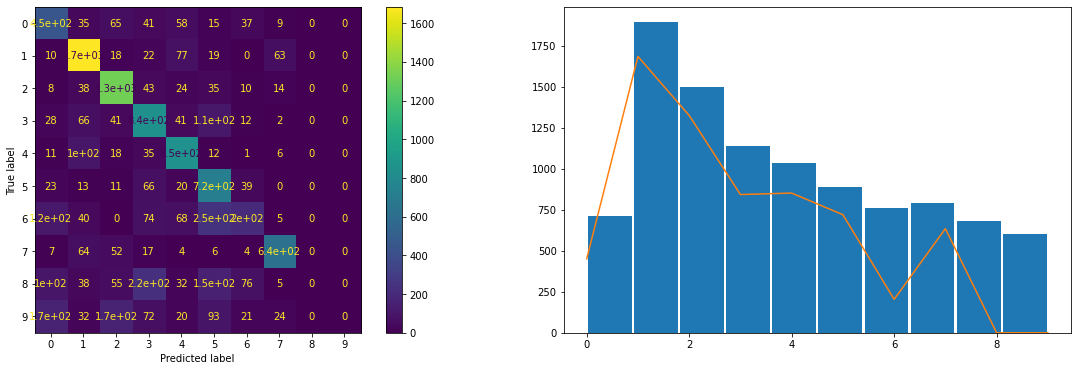

In [ ]:
eval_model(model_baseline, X_test, Y_test)

The model doesn't work that well.

We have massive class imbalance, and this doesn't help us. 

### Adjusting Class Weights

Let's try to derive class weight and input into our model.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train.flatten()),
                                                 Y_train.flatten())
print(class_weights)

[1.66666667 0.57142857 0.65359477 0.83333333 0.95238095 1.07526882
 1.36986301 1.17647059 1.38888889 1.5625    ]


In [ ]:
model_baseline = build_model(10)
model_baseline.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_baseline.fit(X_train, Y_train,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(X_test, Y_test),
                        class_weight=dict(enumerate(class_weights)))

Epoch 1/100
8/8 [==============================] - 6s 794ms/step - loss: 2.3231 - accuracy: 0.0890 - val_loss: 2.3195 - val_accuracy: 0.0758
Epoch 2/100
8/8 [==============================] - 6s 779ms/step - loss: 2.3098 - accuracy: 0.1190 - val_loss: 2.3015 - val_accuracy: 0.0760
Epoch 3/100
8/8 [==============================] - 6s 781ms/step - loss: 2.3088 - accuracy: 0.1430 - val_loss: 2.2866 - val_accuracy: 0.1600
Epoch 4/100
8/8 [==============================] - 6s 781ms/step - loss: 2.3138 - accuracy: 0.1320 - val_loss: 2.3024 - val_accuracy: 0.1141
Epoch 5/100
8/8 [==============================] - 6s 789ms/step - loss: 2.3021 - accuracy: 0.1460 - val_loss: 2.3073 - val_accuracy: 0.1221
Epoch 6/100
8/8 [==============================] - 6s 787ms/step - loss: 2.2886 - accuracy: 0.1370 - val_loss: 2.3499 - val_accuracy: 0.0727
Epoch 7/100
8/8 [==============================] - 6s 779ms/step - loss: 2.2982 - accuracy: 0.1380 - val_loss: 2.3314 - val_accuracy: 0.0943
Epoch 8/100
8

313/313 - 5s - loss: 1.6741 - accuracy: 0.7859
Test loss: 1.6740769147872925
Test accuracy: 0.7858999967575073


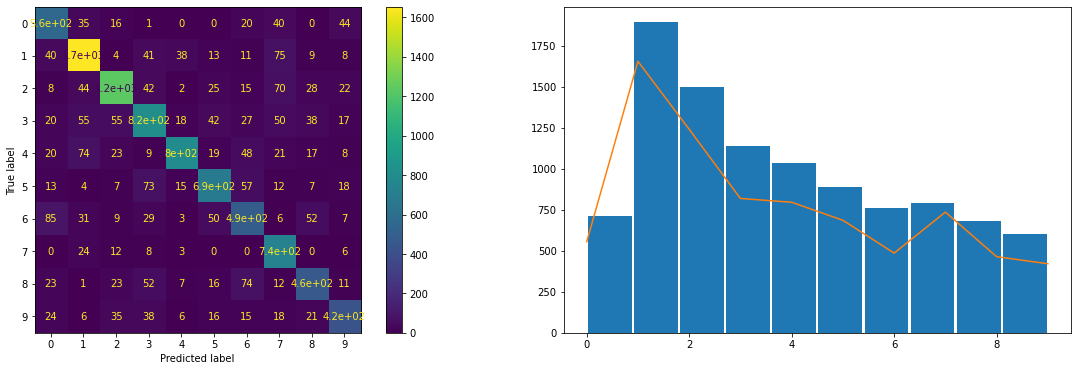

In [ ]:
eval_model(model_baseline, X_test, Y_test)

### With Augmentation
We will use the following:
* moderate translations
* small rotations
* moderate scale changes
* reflections on the X-axis

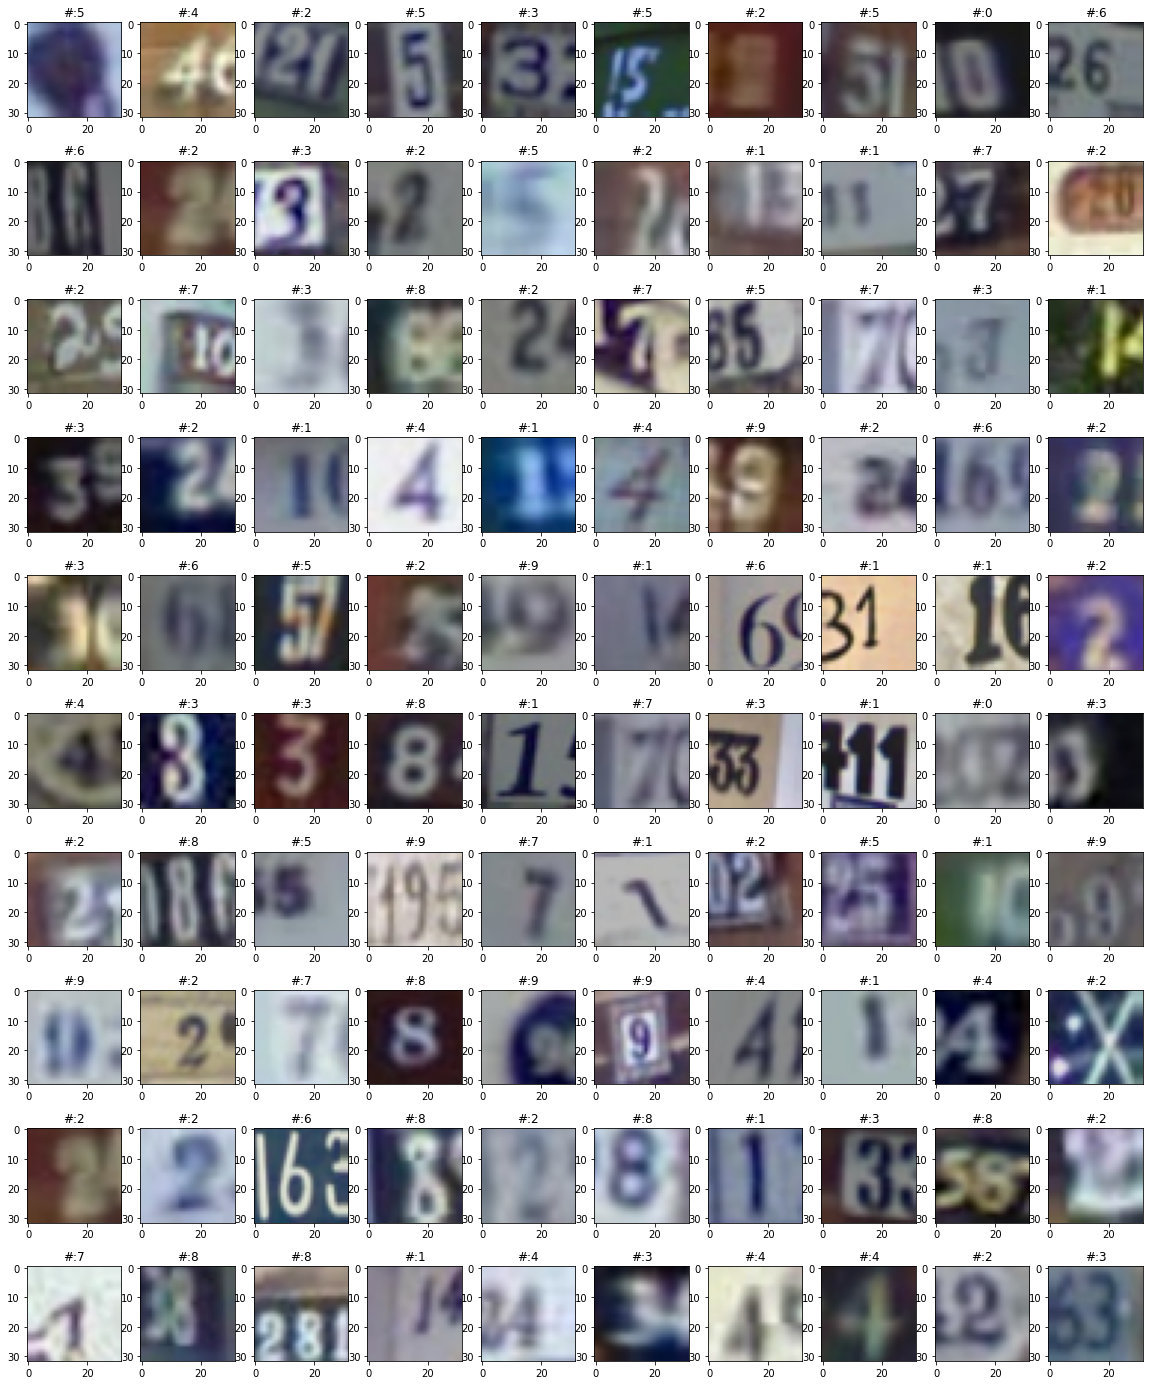

In [ ]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for zooming
                            zoom_range=0.1,
                            # Darkness
                            brightness_range=[0.5,1.0],
                            # Fill blank pixel with nearest pixel
                            fill_mode="nearest")

batch = datagen.flow(X_train, Y_train, batch_size=2000)
X_train_aug = batch[0][0].astype('uint8')
Y_train_aug = batch[0][1]

fig = plt.figure(figsize=[20, 25])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(X_train_aug[i,:,:,:])
    ax.set_title('#:' + '%d' % Y_train_aug[i])

In [ ]:
# Class Weight for Augmented data
class_weights_aug = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train_aug.flatten()),
                                                 Y_train_aug.flatten())
print(class_weights_aug)

[1.66666667 0.57142857 0.65359477 0.83333333 0.95238095 1.07526882
 1.36986301 1.17647059 1.38888889 1.5625    ]


In [ ]:
history = model_baseline.fit(X_train_aug, Y_train_aug,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(X_test, Y_test),
                        class_weight=dict(enumerate(class_weights_aug)))

Epoch 1/100
8/8 [==============================] - 6s 784ms/step - loss: 1.6494 - accuracy: 0.8260 - val_loss: 1.6727 - val_accuracy: 0.7848
Epoch 2/100
8/8 [==============================] - 6s 792ms/step - loss: 1.6533 - accuracy: 0.8140 - val_loss: 1.6783 - val_accuracy: 0.7794
Epoch 3/100
8/8 [==============================] - 6s 796ms/step - loss: 1.6574 - accuracy: 0.8150 - val_loss: 1.6711 - val_accuracy: 0.7845
Epoch 4/100
8/8 [==============================] - 6s 804ms/step - loss: 1.6563 - accuracy: 0.8090 - val_loss: 1.6733 - val_accuracy: 0.7869
Epoch 5/100
8/8 [==============================] - 6s 792ms/step - loss: 1.6417 - accuracy: 0.8300 - val_loss: 1.6626 - val_accuracy: 0.7975
Epoch 6/100
8/8 [==============================] - 6s 796ms/step - loss: 1.6160 - accuracy: 0.8460 - val_loss: 1.6683 - val_accuracy: 0.7887
Epoch 7/100
8/8 [==============================] - 6s 802ms/step - loss: 1.6192 - accuracy: 0.8370 - val_loss: 1.6922 - val_accuracy: 0.7679
Epoch 8/100
8

313/313 - 5s - loss: 1.6524 - accuracy: 0.8082
Test loss: 1.6524103879928589
Test accuracy: 0.8082000017166138


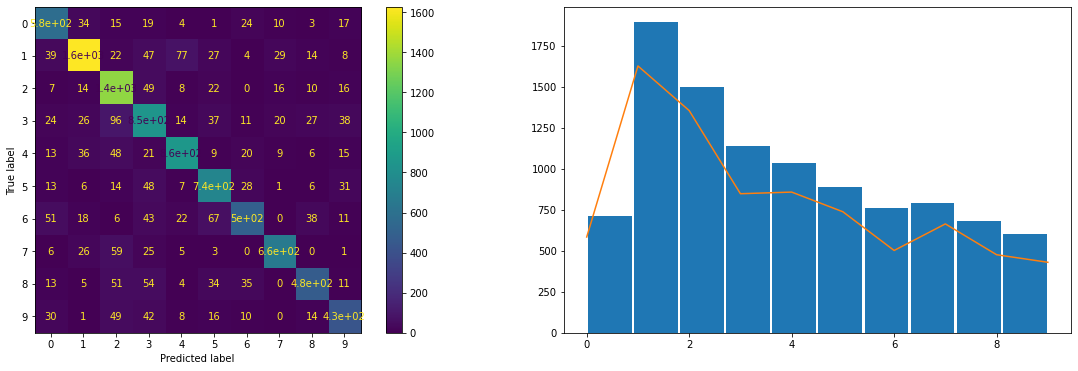

In [ ]:
eval_model(model_baseline, X_test, Y_test)

### Fine Tuning
Here we use CIFAR-10 model to fine tune. Reason is there are of the same image size as our data source. (32 wide, 32 high, 3 color channels)

In [ ]:
model_vgg = keras.models.load_model('/content/drive/My Drive/CAB420/Assignment 1A/vgg_3stage_CIFAR_small.h5')
model_vgg.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_24 (Spatia (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 8)         0

In [ ]:
for layer in model_vgg.layers[:-5]:
    layer.trainable = False

for layer in model_vgg.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1c64577eb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1c64bf1630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1c645812b0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1c645817b8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f1c64581b00> False
<tensorflow.python.keras.layers.core.SpatialDropout2D object at 0x7f1c64581cc0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1c64581eb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1c64581278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1c64636f60> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1c64581710> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f1c64583940> False
<tensorflow.python.keras.layers.core.Spati

In [ ]:
model_vgg.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
history = model_vgg.fit(X_train, Y_train,
                        batch_size=128,
                        epochs=20,
                        validation_data=(X_test, Y_test),
                        class_weight=dict(enumerate(class_weights)))

Epoch 1/20
8/8 [==============================] - 6s 769ms/step - loss: 4.3476 - accuracy: 0.0870 - val_loss: 10.3130 - val_accuracy: 0.1012
Epoch 2/20
8/8 [==============================] - 6s 752ms/step - loss: 4.1429 - accuracy: 0.1080 - val_loss: 6.8589 - val_accuracy: 0.1085
Epoch 3/20
8/8 [==============================] - 6s 753ms/step - loss: 4.1579 - accuracy: 0.0990 - val_loss: 5.3704 - val_accuracy: 0.1098
Epoch 4/20
8/8 [==============================] - 6s 749ms/step - loss: 3.9292 - accuracy: 0.1040 - val_loss: 4.5781 - val_accuracy: 0.1089
Epoch 5/20
8/8 [==============================] - 6s 750ms/step - loss: 3.9759 - accuracy: 0.0810 - val_loss: 4.1079 - val_accuracy: 0.1139
Epoch 6/20
8/8 [==============================] - 6s 755ms/step - loss: 3.9204 - accuracy: 0.0940 - val_loss: 3.7923 - val_accuracy: 0.1103
Epoch 7/20
8/8 [==============================] - 6s 757ms/step - loss: 3.8434 - accuracy: 0.1080 - val_loss: 3.5919 - val_accuracy: 0.1102
Epoch 8/20
8/8 [===

With Data Augmentation

In [ ]:
history = model_vgg.fit(X_train_aug, Y_train_aug,
                        batch_size=128,
                        epochs=10,
                        validation_data=(X_test, Y_test),
                        class_weight=dict(enumerate(class_weights_aug)))

Epoch 1/10
8/8 [==============================] - 6s 753ms/step - loss: 3.1808 - accuracy: 0.1010 - val_loss: 2.8007 - val_accuracy: 0.1069
Epoch 2/10
8/8 [==============================] - 6s 756ms/step - loss: 3.1442 - accuracy: 0.1120 - val_loss: 2.7784 - val_accuracy: 0.1075
Epoch 3/10
8/8 [==============================] - 6s 757ms/step - loss: 3.1695 - accuracy: 0.1050 - val_loss: 2.7592 - val_accuracy: 0.1076
Epoch 4/10
8/8 [==============================] - 6s 758ms/step - loss: 3.1057 - accuracy: 0.1040 - val_loss: 2.7424 - val_accuracy: 0.1087
Epoch 5/10
8/8 [==============================] - 6s 757ms/step - loss: 3.1225 - accuracy: 0.1080 - val_loss: 2.7247 - val_accuracy: 0.1091
Epoch 6/10
8/8 [==============================] - 6s 762ms/step - loss: 3.0889 - accuracy: 0.1030 - val_loss: 2.7070 - val_accuracy: 0.1100
Epoch 7/10
8/8 [==============================] - 6s 757ms/step - loss: 3.0361 - accuracy: 0.1100 - val_loss: 2.6905 - val_accuracy: 0.1102
Epoch 8/10
8/8 [====

313/313 - 7s - loss: 2.6489 - accuracy: 0.1131
Test loss: 2.6489484310150146
Test accuracy: 0.11309999972581863


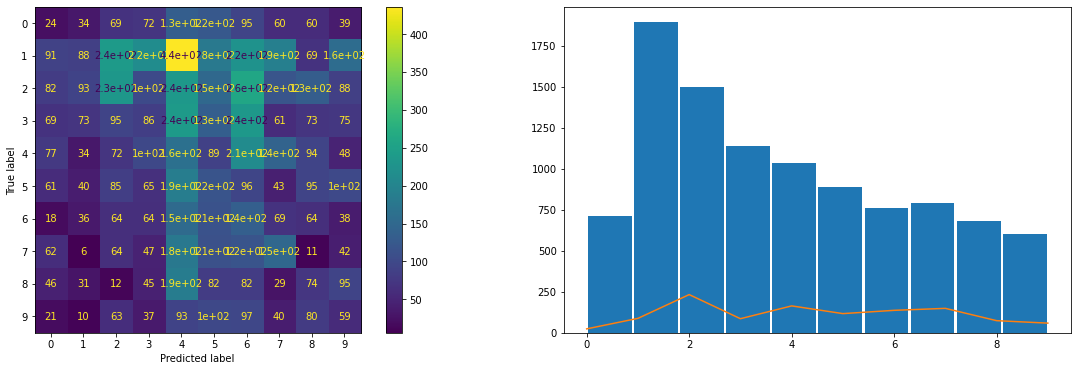

In [ ]:
eval_model(model_vgg, X_test, Y_test)